In [111]:
import calendar
import datetime as dt
import time
import random
import re

import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.size': 14})
import pandas as pd
import pygsheets as pygs
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()
from labellines import labelLines

from config import GS_ACCOUNT_FILE, RU_MONTH_NAMES


gs_client = pygs.authorize(service_account_file=GS_ACCOUNT_FILE)

# Retrieve the data from Google Sheets

In [2]:
class RawData:

    def __init__(self, 
                 mindate=dt.date(2021, 5, 1), 
                 maxdate=dt.date.today()):
        self.mindate = mindate
        self.maxdate = maxdate

    def get(self) -> pd.DataFrame:
        spreadsheets = self._open_spreadsheets()
        worksheets = [ws for sh in spreadsheets for ws in sh]
        worksheets = [ws for ws in worksheets
                      if self.mindate <= 
                      pd.to_datetime(ws.title, dayfirst=True).date() 
                      <= self.maxdate]

        dfs = []
        pbar = tqdm_notebook(worksheets)
        pbar.set_description('Proceessing worksheets')
        for ws in pbar:
            dfs.append(self._to_df(ws))
            time.sleep(0.6)

        return pd.concat(dfs).sort_index()

    def _open_spreadsheets(self) -> list[pygs.Spreadsheet]:
        conditions = ["name contains 'MonNom - Бронь'", 
                      "not name contains 'Copy'", 
                      self._dates_condition]
        query = ' and '.join(conditions)
        return gs_client.open_all(query)
    
    @property
    def _dates_condition(self) -> str:
        dates_conditions = [f"name contains '{m_y}'" 
                            for m_y in self._filename_monthyears]
        return f"({' or '.join(dates_conditions)})"    
    
    @property
    def _filename_monthyears(self) -> list[str]:
        monthyears = {d.strftime("%Y-%m") 
                      for d in pd.date_range(self.mindate, self.maxdate)}
        return [self._convert_to_filename_monthyear(my) 
                for my in monthyears]

    @staticmethod
    def _convert_to_filename_monthyear(monthyear: str) -> str:
        year, month = monthyear.split("-")
        monthname = RU_MONTH_NAMES[int(month) - 1]
        return monthname + " " + year

    @staticmethod
    def _to_df(ws) -> pd.DataFrame:
        date = ws.title
        df = ws.get_as_df(start='A2', index_column=1)
        df.index = df.index + ' ' + date
        df.index = pd.to_datetime(df.index, dayfirst=True)
        return df

In [3]:
class ProcessedData:

    def __init__(self,
                 mindate=dt.date(2021, 5, 1),
                 maxdate=dt.date.today()):
        self.rdata = RawData(mindate, maxdate).get()

    def get(self) -> pd.DataFrame:
        reservations = []
        for gs in self._guest_strings:
            for row in self._process_guest_string(gs):
                reservations.append(row)
        df = pd.DataFrame(reservations)
        df.set_index('DateTime', inplace=True)
        df.sort_index(inplace=True)
        return df

    @property
    def _guest_strings(self) -> np.ndarray:  # [str]?
        guest_cells = self.rdata.applymap(self._guest_regex)
        guest_list = guest_cells.values.reshape(-1)
        guest_list = guest_list[~pd.isnull(guest_list)]  # try np.isnan
        return np.unique(guest_list)

    def _process_guest_string(self, guest: str) -> list[dict]:
        rows, cols = np.where(self.rdata == guest)
        coords_list = list(zip(rows, cols))

        guest = guest.strip()

        # guest may have multiple reservations
        reservations = []

        for coords in coords_list:
            row, col = coords

            date_time = self.rdata.index[row]
            table = self.rdata.columns[col]
            capacity = int(table.split('\n👤 ')[1])
            table = table.split('\n')[0]
            name = guest.split(' ')[0]
            phone = self._get_phone(guest)
            persons = self._get_persons(guest)
            comment = self._guest_regex(guest, get_comment=True)
            duration = self._get_duration(row, col)

            reservation = {
                'DateTime': date_time,
                'Table': table,
                'Capacity': capacity,
                'Name': name,
                'Phone': phone,
                'Persons': persons,
                'Duration': duration,
                'Comment': comment
            }

            reservations.append(reservation)

        return reservations

    @staticmethod
    def _guest_regex(cell: str, get_comment=False) -> str | None:
        guest = r'(.{2,}\s(\d+\sчел|\d+\s[чЧ]|\d+[чЧ])\s(\d{9,12}|\d{2}\s\d{7}))'
        match = re.search(guest, cell)
        if match:
            if get_comment:
                return cell.replace(match.group(0), '')
            else:
                return cell

    @staticmethod
    def _get_phone(guest_string: str) -> str | None:
        phone = r'\d{9,12}|\d{2}\s\d{7}'
        match = re.search(phone, guest_string)
        if match:
            return match.group(0).replace(' ', '')

    @staticmethod
    def _get_persons(guest_string: str) -> int | None:
        match = re.search(r'\d+\sчел|\d+\s[чЧ]|\d+[чЧ]', guest_string)
        if match:
            persons = re.search(r'\d+', match.group(0)).group(0)
            return int(persons)

    def _get_duration(self, row: int, col: int) -> float:
        reservation_cells = ['о', 'х', 'o', 'x']  # latin and cyrillic
        reservation_cells += [i.upper() for i in reservation_cells]

        duration = 0.5
        n = 1

        try:
            while (cell_bellow := self.rdata.iloc[row + n, col]) in reservation_cells:
                duration += 0.5
                n += 1
        except IndexError:
            # worksheet ends
            pass

        return duration

In [4]:
df = ProcessedData(dt.date(2021, 6, 1), dt.date(2022, 3, 31)).get()

  0%|          | 0/304 [00:00<?, ?it/s]

# Analyse the data

In [143]:
sample = df.sample(10)

# obfuscate phone numbers
R = random.randint(1, 10**5)
sample['Phone'] = sample['Phone'].apply(lambda x: int(x) + R)
sample

,Table,Capacity,Name,Phone,Persons,Duration,Comment
DateTime,,,,,,,
2021-09-21 10:00:00,201,4,денис,292637691,2,2.0,др подруги
2021-09-17 13:30:00,205,3,александр,298829911,2,1.5,
2021-08-21 15:30:00,206,12,елена,292671769,4,2.0,
2021-09-12 11:00:00,104,2,катя,293581860,3,2.5,
2021-10-23 14:00:00,102,5,юлия,298444813,3,2.0,др
2022-03-11 20:30:00,202,3,екатерина,296553244,2,1.0,
2022-03-24 19:00:00,207,2,лиза,445625047,2,2.0,
2021-09-18 17:00:00,106,3,дмитрий,447586455,2,2.5,
2021-08-31 16:00:00,104,2,полина,296674539,2,2.5,


In [5]:
def set_month_ticks(xaxis: mpl.axis.XAxis) -> None:
    
    xaxis.set_major_locator(mpl.dates.YearLocator())
    xaxis.set_major_formatter(mpl.dates.DateFormatter("%b\n%Y"))

    xaxis.set_minor_locator(mpl.dates.MonthLocator())
    xaxis.set_minor_formatter(mpl.dates.DateFormatter("%b"))

## Reservations per month

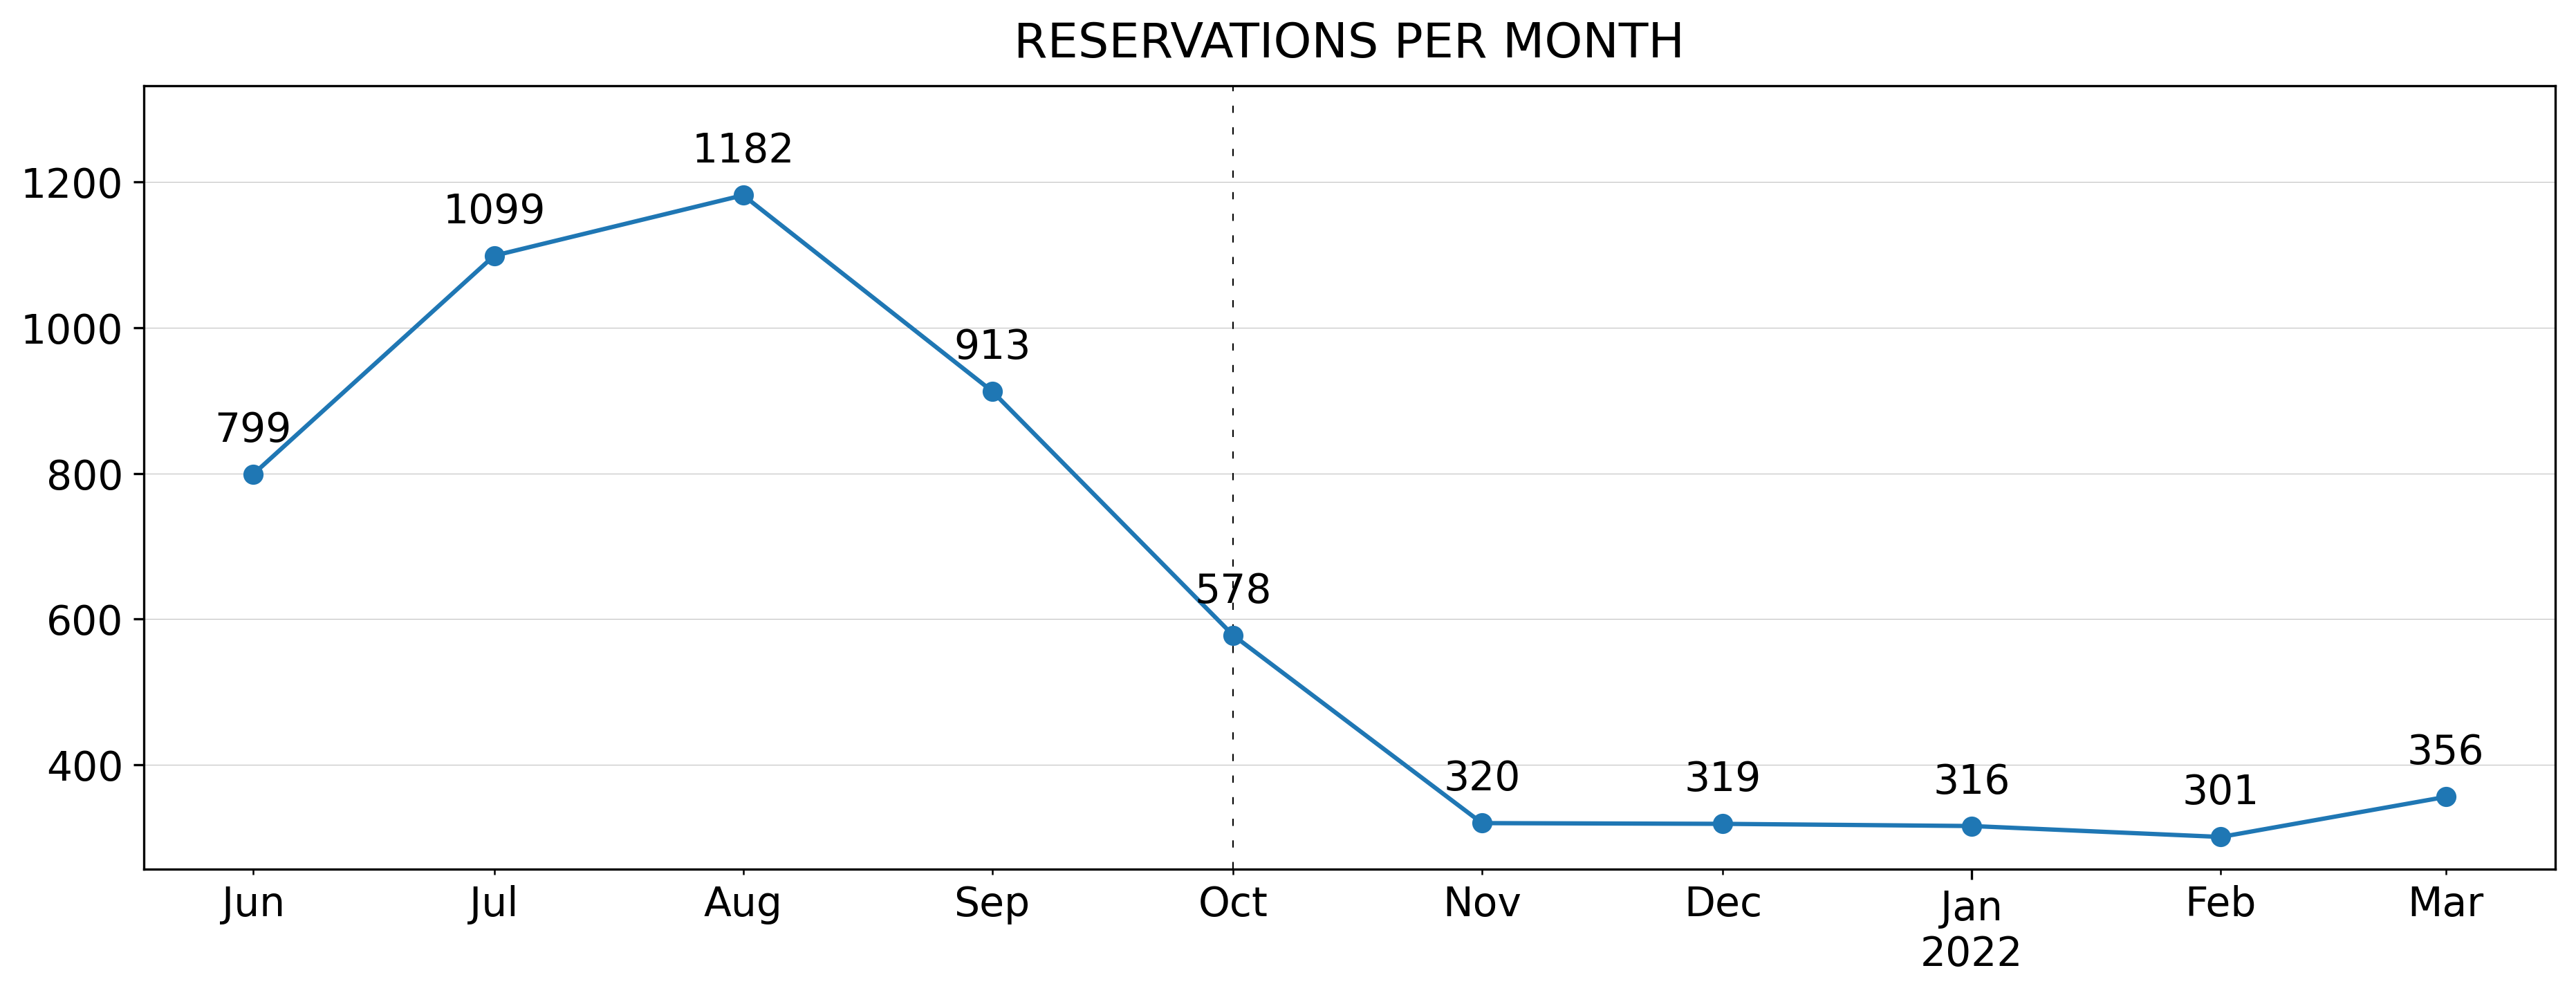

In [153]:
title = "reservations per month"

r = df.resample("MS").size()

fig, ax = plt.subplots(num=1, figsize=(15, 5), clear=True)

october21 = ax.axvline(
    x=pd.Timestamp("2021-10"), 
    color="black", linestyle=(0, (5, 10)), linewidth=0.5)

ax.plot_date(r.index, r, linestyle='solid')

# add value labels
for index, value in r.iteritems():
    ax.text(index, value + 45, value, {'ha': 'center'})
    
set_month_ticks(ax.xaxis)

ax.set_ylim(top=r.max()+150)
ax.grid(axis='y', linewidth=0.2)
ax.set_title(title.upper(), pad=10)

fig.savefig(f"graphs/{title.replace(' ', '_')}.jpg")

## Table popularity

In [7]:
tp = df.resample("MS").Table.value_counts(normalize=True)  

months = tp.index.get_level_values(0).unique()

# tables need to be plotted in the order of their 
# last month popularity values for correct choise of colors
tables = tp.loc[months[-1], :].index.get_level_values(1)

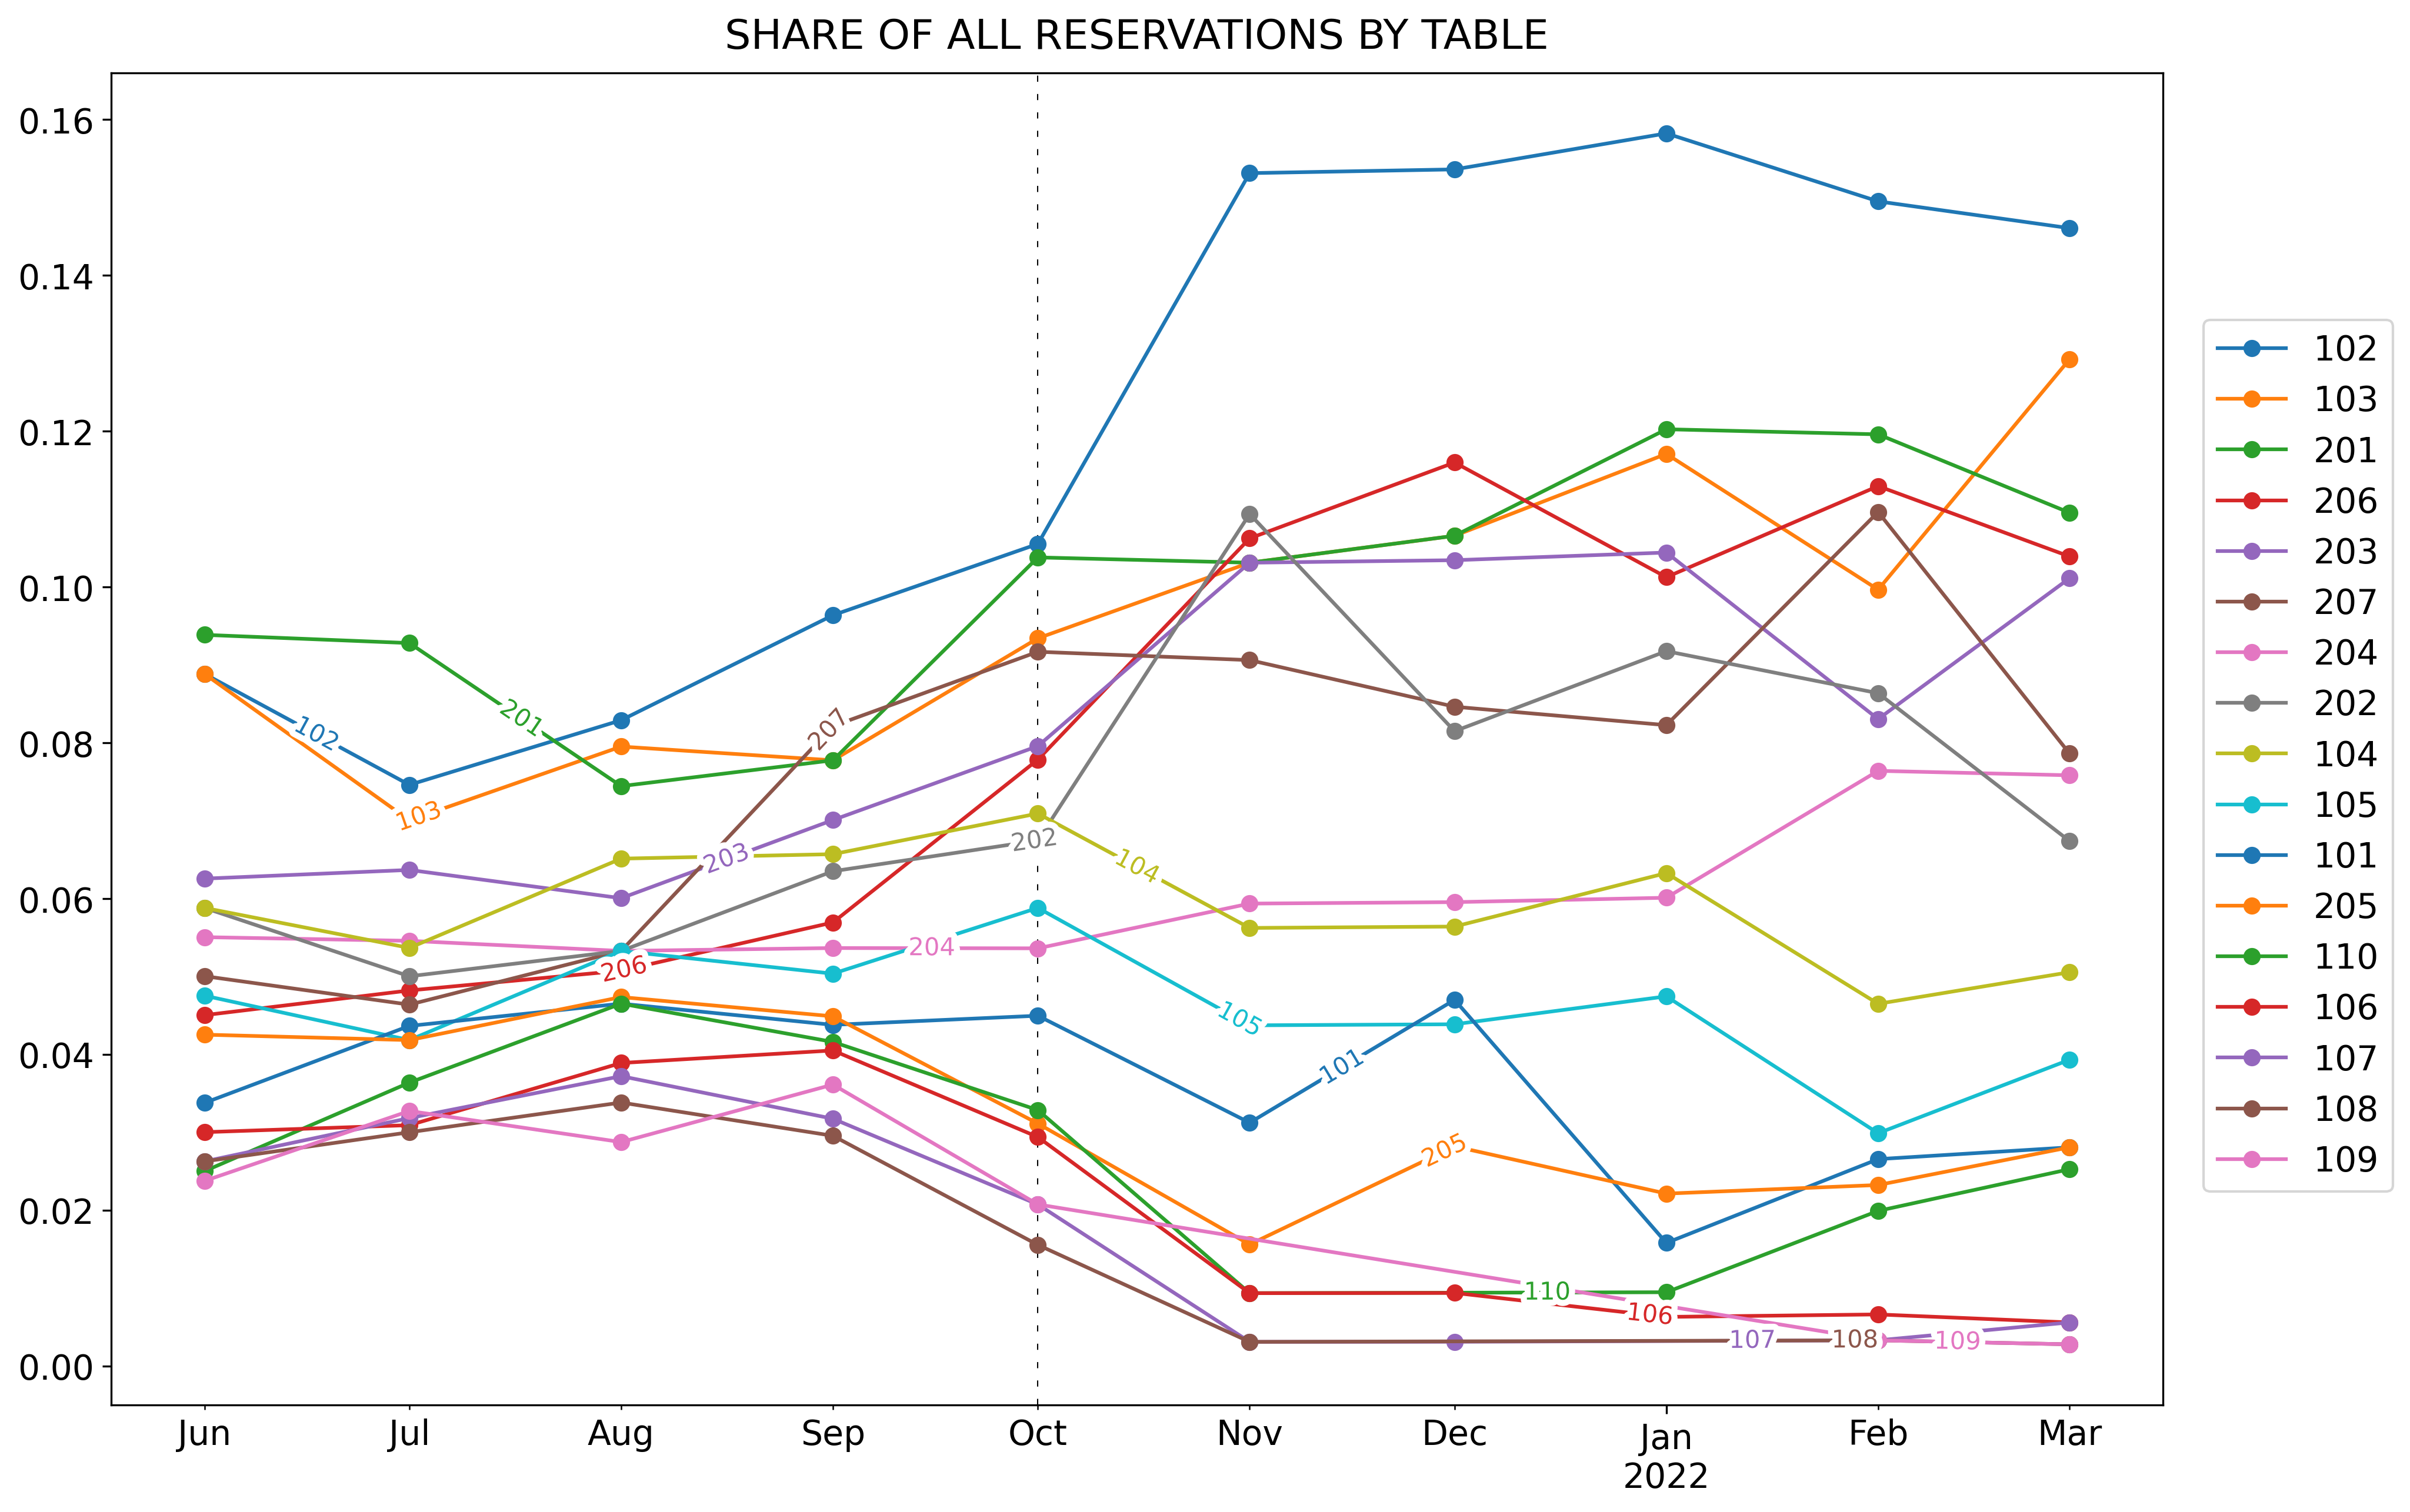

In [155]:
title = "share of all reservations by table"

fig, ax = plt.subplots(num=1, figsize=(15, 10), clear=True)

october21 = ax.axvline(
    x=pd.Timestamp("2021-10"), 
    color="black", linestyle=(0, (5, 10)), linewidth=0.5)

for t in tables:
    
    # Exclude the terrace
    if t.startswith("3"):
        continue
    
    t_data = tp.loc[:, t]
    ax.plot_date(t_data.index, t_data, label=t, linestyle='solid')
    
labelLines(ax.get_lines()[1:], fontsize=10)

ax.legend(loc=(1.02, 0.16))
set_month_ticks(ax.xaxis)
ax.set_title(title.upper(), pad=10)

fig.savefig(f"graphs/{title.replace(' ', '_')}.jpg")

## Rush hours

In [9]:
hour_intervals = pd.interval_range(10, 22, 3, closed='left')

r = df.groupby([df.index.day_of_week, 
                pd.cut(df.index.hour, hour_intervals)]).size()
r = pd.DataFrame(r, columns=['total'])
r['average'] = ''

weekdays, counts = np.unique(
    [d.weekday() for d in np.unique(df.index.date)], 
    return_counts=True)

for wd in weekdays:
    r.loc[(wd, slice(None)), 'average'] = r.loc[(wd, slice(None)), 'total'] / counts[wd]

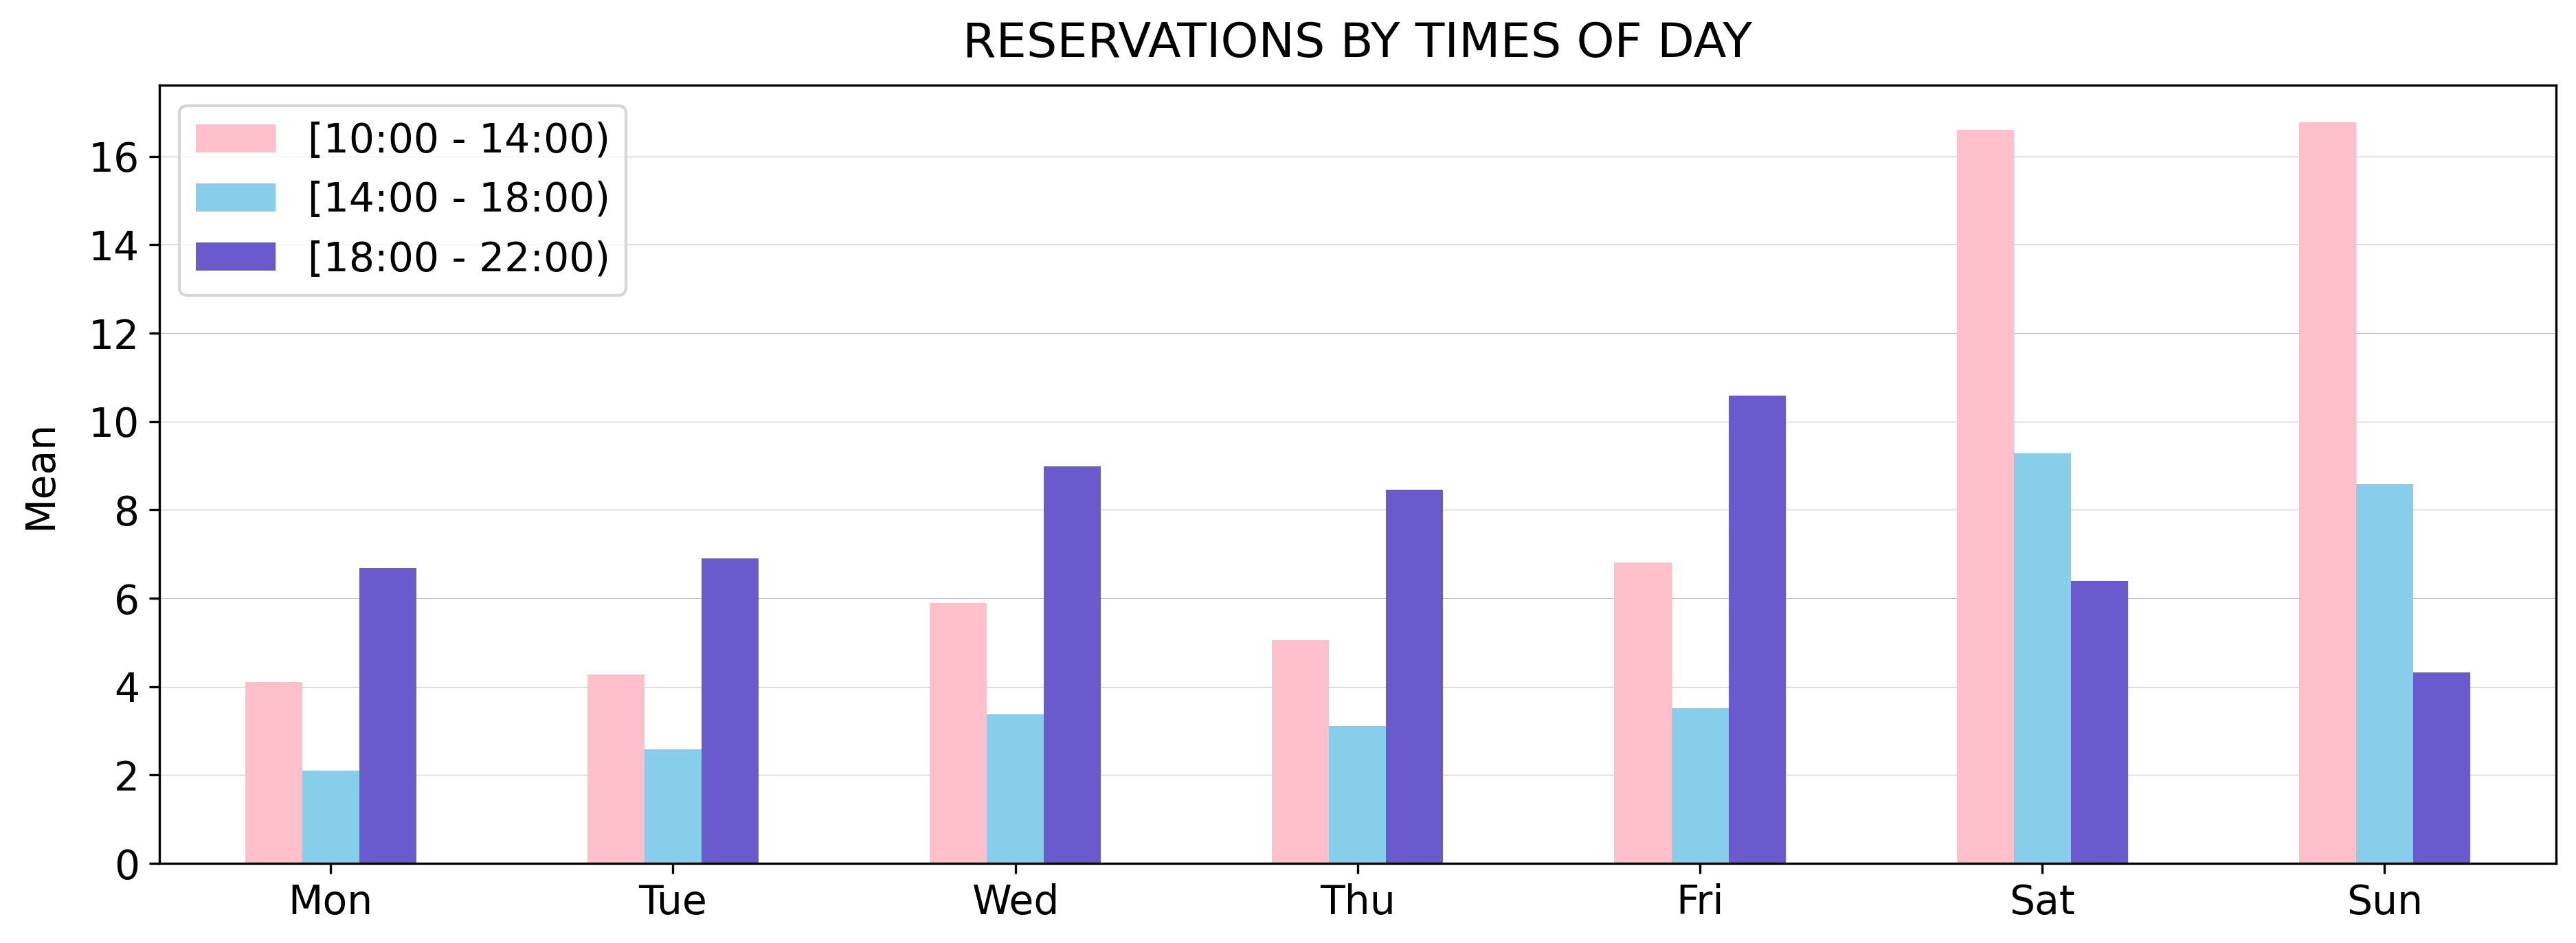

In [146]:
title = "reservations by times of day"

fig, ax = plt.subplots(num=1, figsize=(15, 5), clear=True)

avg = r.unstack()['average']
avg = avg.rename(columns=lambda x: f"[{x.left}:00 - {x.right}:00)")

avg.plot.bar(ax=ax, color=['pink', 'skyblue', 'slateblue'], xlabel="")

ax.legend(prop={'size': 14})
ax.set_xticklabels(tuple(calendar.day_abbr), rotation=0)
ax.set_axisbelow(True)
ax.grid(axis='y', linewidth=0.2)

ax.set_title(title.upper(), pad=10)
ax.set_ylabel("Mean", labelpad=10)

fig.savefig(f"graphs/{title.replace(' ', '_')}.jpg")

## Reservations genders

In [12]:
from gender_guesser.detector import Detector
from transliterate import translit

d = Detector()

In [50]:
def guess_gender(name: str) -> str:
    name = name.capitalize()
    name = translit(name, "ru", reversed=True).replace("'", "")
    guess = d.get_gender(name)
    return guess if guess in ["male", "female"] else "unknown"

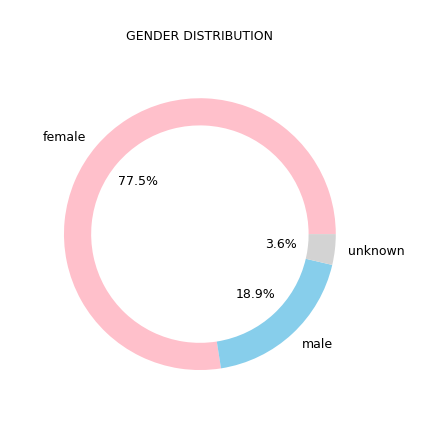

In [156]:
title = "gender distribution"

df['Gender'] = df['Name'].apply(guess_gender)
genders = df.Gender.value_counts()

fig, ax = plt.subplots(num=1, figsize=(1.5, 1.5), clear=True)

ax.pie(genders, 
       labels=genders.index, 
       colors=['pink', 'skyblue', 'lightgrey'],
       textprops={'size': 3}, 
       autopct='%1.1f%%',
       wedgeprops={'width': 0.2}
      )

ax.set_title(title.upper(), fontsize=3)
fig.savefig(f"graphs/{title.replace(' ', '_')}.jpg")